In [1]:
import time
import math
import matplotlib.pyplot as plt

In [2]:
class PositionEstimator:
    '''
    A PositionEstimator that uses accelerometer and gyroscope readings of an imu to 
    predict position in-between readings from a gps, due to their difference in update
    frequencies. 

    Should be used unthreaded if there is not a significant difference
    between the gps update frequency and donkey loop frequency.

    Should be used threaded only when testing estimator effectiveness;
    the estimated position is only useful when the autopilot (an unthreaded part)
    needs to calculate error (CTE, also unthreaded) for steering values.

    In order to allow the autopilot to use the estimations at a higher frequency,
    the donkey loop frequency needs to be increased.
    '''

    def __init__(self):
        # position, velocity, and orientation values
        self.x = 0.
        self.y = 0.
        self.vx = 0.
        self.vy = 0.
        self.yaw = 0.

    def run(self, acl_x: float, acl_y: float, gyr_x: float, pos_x: float, pos_y: float):
        # updates stored velocity, orientation, and position using accelerometer and gyroscope readings

        dt = .05

        # update orientation
        # also convert from radians to degrees
        self.yaw += float(gyr_x) * dt

        # lock yaw to -180 -> 180 frame
        if self.yaw*(180/math.pi) > 180:
            # move from north-facing to south-facing
            self.yaw -= 360*math.pi/180
        elif self.yaw*(180/math.pi) < -180:
            # move from south-facing to north-facing
            self.yaw += 360*(math.pi/180)


        # rotate accerlation vectors; apply trig then adjust signage according to heading
        head = ''

        if self.yaw >= 0 and self.yaw < 90*(math.pi/180):
            # within 90 deg, no adjustment needed for trig
            ax = float(acl_x) * math.cos(self.yaw) - float(acl_y) * math.sin(self.yaw)
            ay = float(acl_x) * math.sin(self.yaw) - float(acl_y) * math.cos(self.yaw)
            # facing NE, x and y comps are positive (no change)
            head = 'NE'
            #print(round(self.yaw*(180/math.pi)), head, self.yaw)
        elif self.yaw >= 90*(math.pi/180):
            # exceeds 180 deg, needs adjust for trig
            ax = float(acl_x) * math.cos(180*(math.pi/180) - self.yaw) - float(acl_y) * math.sin(180*(math.pi/180) - self.yaw)
            ay = float(acl_x) * math.sin(180*(math.pi/180) - self.yaw) - float(acl_y) * math.cos(180*(math.pi/180) - self.yaw)
            # facing NW, x comp is negative
            ax *= -1
            head = 'NW'
            #print(round(self.yaw*(180/math.pi)), head,180*(math.pi/180) - self.yaw)
        elif self.yaw < 0 and self.yaw >= -90*(math.pi/180):
            # within 90 deg, no adjustment needed for trig
            ax = float(acl_x) * math.cos(-self.yaw) - float(acl_y) * math.sin(-self.yaw)
            ay = float(acl_x) * math.sin(-self.yaw) - float(acl_y) * math.cos(-self.yaw)
            # facing SE, y comp is negative
            ay *= -1
            head = 'SE'
            #print(round(self.yaw*(180/math.pi)), head, -self.yaw)
        elif self.yaw <= -90*(math.pi/180):
            # exceeds 180 deg, needs adjust for trig
            ax = float(acl_x) * math.cos(self.yaw + 180*(math.pi/180)) - float(acl_y) * math.sin(self.yaw + 180*(math.pi/180))
            ay = float(acl_x) * math.sin(self.yaw + 180*(math.pi/180)) - float(acl_y) * math.cos(self.yaw + 180*(math.pi/180))
            # facing SW, x and y comps are negative
            ax *= -1
            ay *= -1
            head = 'SW'
            #print(round(self.yaw*(180/math.pi)), head, self.yaw + 180*(math.pi/180))
        # print orientation and adjusted accleration
        print(round(self.yaw*(180/math.pi)), head, ax, ay)

        # update velocity
        self.vx += ax * dt
        self.vy += ay * dt

        # update stored position
        self.x += self.vx * dt
        self.y += self.vy * dt

        return ax, ay, self.yaw

In [54]:
class PositionEstimator:
    '''
    A PositionEstimator that uses accelerometer and gyroscope readings of an imu to 
    predict position in-between readings from a gps, due to their difference in update
    frequencies. 

    Should be used unthreaded if there is not a significant difference
    between the gps update frequency and donkey loop frequency.

    Should be used threaded only when testing estimator effectiveness;
    the estimated position is only useful when the autopilot (an unthreaded part)
    needs to calculate error (CTE, also unthreaded) for steering values.

    In order to allow the autopilot to use the estimations at a higher frequency,
    the donkey loop frequency needs to be increased.
    '''

    def __init__(self):
        # position, velocity, and orientation values
        self.x = 0.
        self.y = 0.
        self.vx = 0.
        self.vy = 0.
        self.yaw = 0.

    def run(self, acl_x: float, acl_y: float, gyr_x: float, pos_x: float, pos_y: float):
        # updates stored velocity, orientation, and position using accelerometer and gyroscope readings

        dt = .05

        # update orientation
        # also convert from radians to degrees
        self.yaw += float(gyr_x) * dt

        # lock yaw to 0->360 frame
        self.yaw %= 360*(math.pi/180)
        # rotate accerlation vectors; apply trig then adjust signage according to heading

        ax = float(acl_x) * math.cos(self.yaw) - float(acl_y) * math.sin(self.yaw)
        ay = float(acl_x) * math.sin(self.yaw) - float(acl_y) * math.cos(self.yaw)
        #print(round(self.yaw*(180/math.pi)), head, ax, ay)

        # update velocity
        self.vx += ax * dt
        self.vy += ay * dt

        # update stored position
        self.x += self.vx * dt
        self.y += self.vy * dt
        
        mock = math.atan(ay / ax)
        if ax > 0 and ay > 0:
            # NE, 0 -> 90
            mock = abs(math.atan(ay / ax))
            print('NE')
        elif ax < 0  and ay > 0:
            # NW, 90 - 180
            mock = 180*(math.pi/180) - abs(math.atan(ay / ax))
            print('NW')
        elif ax < 0 and ay < 0:
            # SW, 180 -> 270
            mock = abs(math.atan(ay / ax)) + 180*(math.pi/180)
            print('SW')
        else:
            # SE, 270 -> 360
            mock = 360*(math.pi*180) - abs(math.atan(ay / ax))
            print('SE')
        mock %= 2*math.pi
        print(mock*180/math.pi)
        return ax, ay, mock

In [55]:
# outputs position estimates without gps signal; very prone to drifting away because of the lack of gps/velocity/position resets,
# but should still output an accurate orientation
print('starting main')
est = PositionEstimator()
print('estimator set')
positions = []
times = []
i=0
while i < 360:
    times += [.05*i]
    # accelerating at 1 m/s^2, rotating with angular velocity 10 rad/s
    accel = 1
    data = [est.run(accel, 0, 20*(math.pi/180), 0, 0)]
    positions += data
    i += 1

starting main
estimator set
NE
1.0
NE
2.0
NE
3.0
NE
4.0
NE
4.999999999999999
NE
6.0
NE
7.0
NE
7.999999999999999
NE
9.0
NE
10.0
NE
10.999999999999998
NE
12.0
NE
12.999999999999998
NE
14.0
NE
14.999999999999998
NE
16.0
NE
17.0
NE
18.0
NE
19.000000000000007
NE
20.00000000000001
NE
21.000000000000007
NE
22.00000000000001
NE
23.000000000000014
NE
24.000000000000014
NE
25.000000000000014
NE
26.000000000000014
NE
27.000000000000018
NE
28.000000000000018
NE
29.000000000000014
NE
30.000000000000014
NE
31.000000000000018
NE
32.00000000000002
NE
33.00000000000003
NE
34.00000000000002
NE
35.00000000000003
NE
36.00000000000003
NE
37.00000000000002
NE
38.00000000000003
NE
39.00000000000003
NE
40.00000000000003
NE
41.000000000000036
NE
42.000000000000036
NE
43.000000000000036
NE
44.00000000000004
NE
45.000000000000036
NE
46.00000000000004
NE
47.00000000000004
NE
48.00000000000004
NE
49.00000000000004
NE
50.00000000000005
NE
51.00000000000004
NE
52.00000000000005
NE
53.00000000000005
NE
54.00000000000

In [56]:
x = [x for x,y,z in positions]
y = [y for x,y,z in positions]
rot = [z for x,y,z in positions]

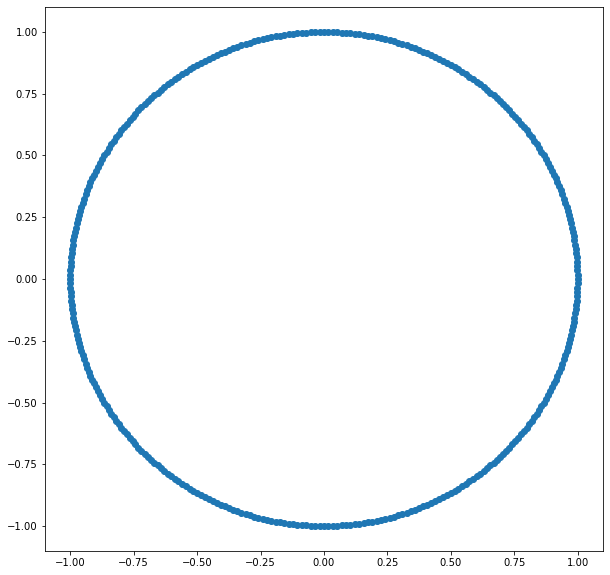

In [57]:
# plot of acceleration while rotating
fig = plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.show()

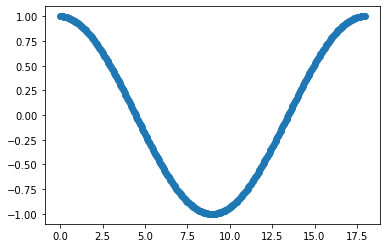

In [58]:
# plot of x-accleration
plt.scatter(times, x)
plt.show()

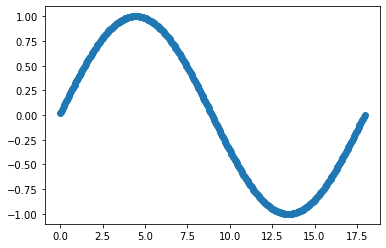

In [59]:
# plot of y-acceleration
plt.scatter(times, y)
plt.show()

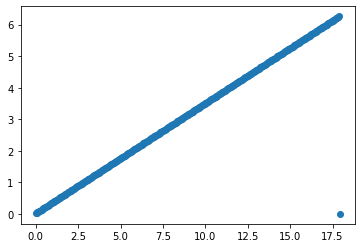

In [60]:
# plot of yaw
plt.scatter(times, rot)
plt.show()